# Imbalanced classes — introduction

In classification you are trying to split data into a number of discrete classes. This works very well if there are equal number of training examples for the different classes but can fall down if one class dominates. In the extreme case when your classifier might always predict the most frequently occuring class. If pure prediction is the goal this can be the correct thing to do, but it could be the case that the infrequent occuring class is more important to you (for example, customers who spend the most might be rarer for a company but more important for the company's business model).

As Provost (_Machine Learning from Imbalanced Data Sets 101_)<sup>[1]</sup> describes it,
>The assumptions built into (most of) these algorithms are: 
> 1. that maximizing accuracy is the goal, and 
> 2. that,  in  use, the  classifier  will  operate  on  data  drawn  from the same distribution as the training data.

This second point is important when, for example, the data you use for training is imblanaced but you expect the live system to be running on more balanced data. These assumptions can be valid so you need to think carefully about whether having imbalanced classes is an issue in any given scenario. Is overall accuracy the goal or do you care equally about accurately predicting different classes?

Most presentations of dealing with imbalanced data assume you do care equally about the two cases, however you might care more amount one class. Continuing the example from above, high spenders at your business might represent 10% of your data but they may account for 90% of revenues. In this case you might not care equally about whether your model is good for low spenders as opposed to high spenders. In one of the sections below _Cost Sensitive Classification_ is discussed which does allow you to specify the costs associated with misclassifying different classes, but the majority of the presentation here will focus on the case where you care equally about the different classes.

The degree that one class dominates the other is not the sole determination of the impact of class imbalance. Class imbalance is likely to be more of a problem for small samples as there is less information (because of fewer data points) abother the minority class. Another factor is the degree of overlap between classes; for a fixed ratio of classes, having well separate classes should result in better results. An additional complication is the degree of homogenity in the classes, you could have very distinct classes (dogs _vs._ cats) or one class might be very broad (dogs _vs._ other animals).

[1]:http://pages.stern.nyu.edu/~fprovost/Papers/skew.PDF

## Terminology

On terminology, when you are building a model to distinguish between two class this is called _binomial classification_ (typically the class are labelled 1 and 0), and if there are more than two classes it is sometimes called multinomial classification and sometimes multiclass classification.

For binomial classification, when the class is imbalanced the class appearing less frequently is known as the minority class (typically labelled 1) and the more frequently appearing class is known as the majority class (typically labelled 0).

The techniques shown in these notebooks can be used for both binomial and multinomial classification but the examples shown are all binomial for brevity.

## Basic example

In [1]:
from __future__ import division

import matplotlib.pyplot as plt

from imblearn.datasets import make_imbalance

from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define a function for plotting data.
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.5)
    plt.show()

To demonstrate class imbalance let's first create and visualise some imbalanced data. This way of building an imbalanced class is based on an example given in the _imbalanced-learn_ package documentation (http://contrib.scikit-learn.org/imbalanced-learn/). Here the data has two classes, with the minority class appearing 15% of the time. The same example will be used throughout these notebooks for consistency.

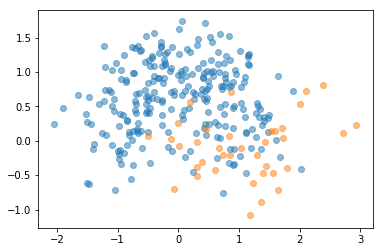

In [2]:
X, y = make_moons(n_samples=500, shuffle=True, noise=0.4, random_state=40)
X_, y_ = make_imbalance(X, y, ratio=0.15, min_c_=1, random_state=40)

# Plot the imbalanced data
plot_data(X_, y_)

Then a simple support vector machine (SVM) classifier can be fitted to it.

In [3]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, stratify=y_, random_state=40 )

# Fit svm model
model = SVC(random_state=40, probability=True)
model.fit(X_train, y_train)

# Make predictions
y_predict = model.predict(X_test)

# Assess the predictive power
print classification_report(y_test, y_predict)

             precision    recall  f1-score   support

          0       0.91      1.00      0.95        83
          1       1.00      0.33      0.50        12

avg / total       0.92      0.92      0.90        95



This classification report shows that whilst the model is good at accurately predicting the majority class it is not good at predicting the minority class. This also shows that if all classes are important to you, looking at metrics such as the f1-score is more important than a pure accuracy score.

## Measuring efficacy

As discussed at the start, one of the assumptions behind classifiers such as the SVM above is that overall accuracy should be minimised. Where accuracy is simplier the proportion of predictions (on the test data) turn out to be correct.

If we do consider accuracy (the proportion of predictions that are correct) we get:

In [4]:
print accuracy_score(y_test, model.predict(X_test))

0.915789473684


The model is doing well but the classifcation report above shows that predictions for the minority class are far from perfect. Looking at precision and recall gives more insight into the data, and f1-score takes more notice of performance on the different classes (as does area under the ROC curve). If the different classes are equally  important to you, f1-score would be worth using to evaluate the model.

If f1-score is more informative why doesn't the model minimise it during fitting? The answer is that using f1-score would not result in a convex cost function, and optimisers for convex problems are very well developed (and performant) so most models only implement convex cost functions.

## Taxonomies

Approaches to tackling imbalances can be catagorised in many different ways. Typically they are catagorised in terms of what you do practically, and for example in the introduction of the paper by Cruz _et al._ (_Tackling Class Imbalance with Ranking_)<sup>[2]</sup> they define the following four catagories:

>**1. Pre-processing** step  changing  the  class  priors  by  under-sampling the majority class and/or creating new synthetic examples of the minority class, or even changing class priors by changing class labels themselves (e.g. MetaCost);

>**2. Training with costs** instead of maximizing accuracy, the training algorithm maximizes weighted accuracy, so that the cost of misclassifying a class is inversely proportional to its frequency;

>**3. Post-processing** by  tweaking  the  decision  boundary  by such  measures  as  changing  a  threshold  after  which  one
class is selected, sometimes with the aid of a ROC curve;

>**4. Ensembles** by which each model within the ensemble is trained  with  balanced  subsets  of  the  data,  coupled with the previous preprocessing techniques.

The paper itself is focused on re-casting the problem as a ranking problem, and also mentions in passing that in some circumstances you can re-cast the problem to be that of anomaly detection.

Ling _et al._ (_Cost Sensitive Learning and the Class Imbalance Problem_)<sup>[3]</sup> provide a different breakdown based more on a theoretical look at class imbalance which shows that there are sounds reasons to tweak probabily thresholds and other techniques (such as MetaCost) are also based around probability thresholds. 

[2]:http://vcmi.inescporto.pt/reproducible_research/ijcnn2016/ClassImbalance/imbalance.pdf
[3]:http://www.csd.uwo.ca/faculty/ling/papers/cost_sensitive.pdf

## Cost of classification

At the heart of a lot of approaches to dealing with imbalanced classes is the idea of the cost of (mis)classification (Ling _et al._ <sup>[3]</sup> provide a good discussion as does Elkan<sup>[4]</sup>). The idea is that classifing a sample (a particular data point) as being in class 0 when it really is class 1 might have a different impact (have a different _cost_) than classifing sample $x_1$ as class 1 when it really is class 0. The cost of classifying a sample as class $i$ when it actually belongs to class $j$ is written as:
$$c_{ij}$$
Interestingly, for the multinomial case, this cost can vary depending on what incorrect class is suggested (not all misclassifications are equal). Also, you still specify "costs" for correct classifications ($c_{ii}$) though these can be thought of as benefits.

Following the notation used by Ling _et al._, the expected cost ($R$) of classifying sample $x$ as class $i$ can be written as:

$$ R\left( i \mid x\right) = \sum_{j} P\left( j \mid x\right) c_{ij} $$
where $P\left( j \mid x\right)$ is the probability that $x$ belongs to class $j$. (Note, the cost/benefit of correct classification, $c_{ii}$, will often be zero.) The principle behing a lot of techniques is to minimise this expected cost. 

These costs can encode our known preferences for different classes. In the case of caring equally about making accurate predictions for two different classes we want the cost of incorrectly labelling an example from the minority class as being from the majority class ($c_{01}$) is $n$ times greater than labelling an example from the majority class as being in the minority class ($c_{10}$), where $n$ is the ratio of the number of samples in the majority class to the number in the minority class.

Many techniques for dealing with imbalanced data are based upon these ideas. Post-processing results via the use of thresholds is probably the most direct application of this idea, followed by training with costs. These two approaches are quick to apply so are demonstrated below rather than in their own notebooks.

[3]:http://www.csd.uwo.ca/faculty/ling/papers/cost_sensitive.pdf
[4]:https://pdfs.semanticscholar.org/2402/9028c1b280c7e62491999824853212ae148c.pdf

## Post-processing results


The idea of post-processing the results is that instead of balancing the input data or tweaking the model to account for the imbalances you instead apply a processing step to the outputs of the model.

Most classification models output the probability that a given data point belongs to each class. A data point is predicted to belong the most probable class. For two class problems here is only really one indepentent probability (since the probabilites sum to one), so instead this process can be thought of as assigning a data point to the minority class if the probability of belonging to it is greater than a threshold value, which by default is taken to be 0.5 (the logical value) but for imbalanced data is often taken to be an additional hyperparameter. Is this approach justified?

Yes. If we think of the problem as one of cost sensitive classification we should be assigning the data point to the class that produces the lowest cost of classification, rather than the most probable class.

For the two class system you would choose class 1 if:

$$ R\left( 1 \mid x\right) < R\left( 0 \mid x\right) $$

which can be written as:

$$ P\left( 1 \mid x\right) > \frac{c_{10}}{c_{10} + c_{01}} $$

In effect minimising the expected cost of classification can be thought of as applying a different probability threshold.

For the example considered here, if we care equally about the two classes then the threshold would be:

In [5]:
c01_c10 = (y_==0).sum() / (y_==1).sum()

threshold = 1 / (1 + c01_c10)

threshold

0.1289198606271777

In [6]:
def make_prediction(data, model, threshold):
    probs = model.predict_proba(data)
    return [1 if prob[1] > threshold else 0 for prob in probs]

y_predict = make_prediction(X_test, model, threshold)
print classification_report(y_test, y_predict)

             precision    recall  f1-score   support

          0       1.00      0.90      0.95        83
          1       0.60      1.00      0.75        12

avg / total       0.95      0.92      0.92        95



This has led to a substanially improvement in the minority class predictions and a small improvement in the majority class prediction.

This has shown that ddjusting the probability threshold does have a solid theoretical basis, though in practice this is often tuned as a hyperparameter rather than dervived as above. The assumption being made is that the trained model is producing accurate probabilities, _i.e._ information about the minority class is correctly being captured. You can imagine scenarios where the model ignores the information from the minority class when training so that the output probabilities are not accurate enough.

## Training with costs

Many algorithms allow you to specify class weights. These are used internally, alogorithms are alterted so that larger penalties are attached to classes with higher weights. The algorithm is then taking the costs of classification into account when fitting the data.

For example with the SVM from before we just make a very simple change:

In [7]:
model = SVC(random_state=40, probability=True, class_weight='balanced')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print classification_report(y_test, y_predict)

             precision    recall  f1-score   support

          0       1.00      0.75      0.86        83
          1       0.36      1.00      0.53        12

avg / total       0.92      0.78      0.81        95



and get poorer results overall (due to a fall in the majority class predictions) but a small improvement in the minority class predictions. Depending on the exact dataset, training with costs can outperform applying a threshold.

Whilst (atleast in _sklearn_) the syntax for specifying weights is common across alot of different techniques, internally the weights are used in different ways. One way in which decisions trees use weights was outlined in Ting's paper _An Instance-Weight Method to Induce Cost-Sensitive Trees_<sup>5</sup> where the criteria for judging where to split the tree is altered to give more weight to the classes with larger weight.

[5]:http://sci2s.ugr.es/keel/pdf/algorithm/articulo/2002%20-%20Ting%20-%20An%20instance-weighting%20method%20to%20induce%20cost-sensitive%20trees%20-%20IEEETKDE.pdf

## Note

The examples here are designed to be illustrations of possible approaches, they are not designed as a benchmark. Not only is the example not representative of classification challenges that you may experience in the wild, hyperparameter tuning has largely been ignored. Different approaches are likely to have different optimal values of the hyperparameters, using optimal values for each model could result in a very different picture of optimal performance. 

Nevertheless this does show that there is merit in all of these approaches.